In [54]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Reading CSV
# thousands parameter is listed so I can convert to float (since the comma was messing things up)
df = pd.read_csv('Google_Stock_Price_Train-1.csv', thousands=',')

# Close price is my target
timeseries = df[['Close']]
timeseries

,Close
0,663.59
1,666.45
2,657.21
3,648.24
4,620.76
...,...
1253,789.91
1254,791.55
1255,785.05
1256,782.79


In [ ]:
# Min max scaled the data
scale = MinMaxScaler()
timeseries = scale.fit_transform(timeseries)


In [ ]:
# 80 20 split
train_size = int(len(timeseries) * 0.8)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

print(f"timeseries: {len(timeseries)}, train: {len(train)}, test: {len(test)}")

timeseries: 1258, train: 1006, test: 252


In [ ]:
# Creating dataset (taken from demo)
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)

lookback = 10
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([996, 10, 1]) torch.Size([996, 10, 1])
torch.Size([242, 10, 1]) torch.Size([242, 10, 1])


In [ ]:
# simple lstm (taken from demo)
class my_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
# LSTM train loop (taken from demo)
# Change num epochs and epoch % count to accomodate
model = my_LSTM()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.1263, test RMSE 0.0746
Epoch 10: train RMSE 0.0311, test RMSE 0.0137
Epoch 20: train RMSE 0.0301, test RMSE 0.0141
Epoch 30: train RMSE 0.0294, test RMSE 0.0131
Epoch 40: train RMSE 0.0289, test RMSE 0.0128
Epoch 50: train RMSE 0.0292, test RMSE 0.0127
Epoch 60: train RMSE 0.0290, test RMSE 0.0130
Epoch 70: train RMSE 0.0295, test RMSE 0.0135
Epoch 80: train RMSE 0.0289, test RMSE 0.0131
Epoch 90: train RMSE 0.0291, test RMSE 0.0137


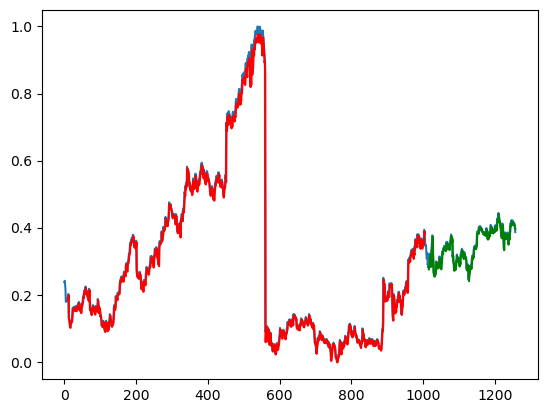

In [ ]:
### Note: The plot shows the min maxed scaled value. I didn't do it, but could have inverse transformed it to get the normal value
# I thought that even if I didn't inverse transform it, the visual would still be the same.
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

From a glance, it would seem like the model is doing well for this simple data. 
Based on the error during training, it is quite low, implying that the model is working well.
From the visual, it is a little hard to see due to the zoom. 
The blue line is the original data, red is training, and green is testing. We can see that both the training and testing lines do seem to overlap quite well with the original data.